# Neuron networks from scratch in Python
References: http://103.203.175.90:81/fdScript/RootOfEBooks/E%20Book%20collection%20-%202024%20-%20G/CSE%20%20IT%20AIDS%20ML/Neural%20Network.pdf

In [55]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()

## Chapter 15: Dropout

In [56]:
# Python
import random
random.seed(0)

dropout_rate = 0.5

example_output = [0.27, -1.03, 0.67, 0.99, 0.05, -0.37, -2.01, 1.13, -0.07, 0.73]

while True:
    index = random.randint(0, len(example_output) - 1)
    example_output[index] = 0

    dropped_out = 0

    for value in example_output:
        if value == 0:
            dropped_out += 1
        
    if dropped_out / len(example_output) == dropout_rate:
        break

print(example_output)

[0, -1.03, 0.67, 0.99, 0, -0.37, 0, 0, 0, 0.73]


In [57]:
# Numpy
np.random.seed(0)
dropout_rate = 0.5
example_output = np.array([0.27, -1.03, 0.67, 0.99, 0.05, -0.37, -2.01, 1.13, -0.07, 0.73])
dropout = np.random.binomial(1, 1 - dropout_rate, example_output.shape).round(2)
example_output *= dropout

print(dropout)
print(example_output)

[1 1 1 1 0 1 0 1 1 0]
[ 0.27 -1.03  0.67  0.99  0.   -0.37 -0.    1.13 -0.07  0.  ]


In [58]:
# Scale
dropout_rate = 0.2

example_output = np.array([0.27, -1.03, 0.67, 0.99, 0.05, -0.37, -2.01, 1.13, -0.07, 0.73])
print(np.sum(example_output))

sums = []

for _ in range(1000000):
    example_output2 = example_output * np.random.binomial(1, 1-dropout_rate, example_output.shape) / (1 - dropout_rate)
    sums.append(np.sum(example_output2))

print(np.mean(sums))

0.36000000000000015
0.3586023125


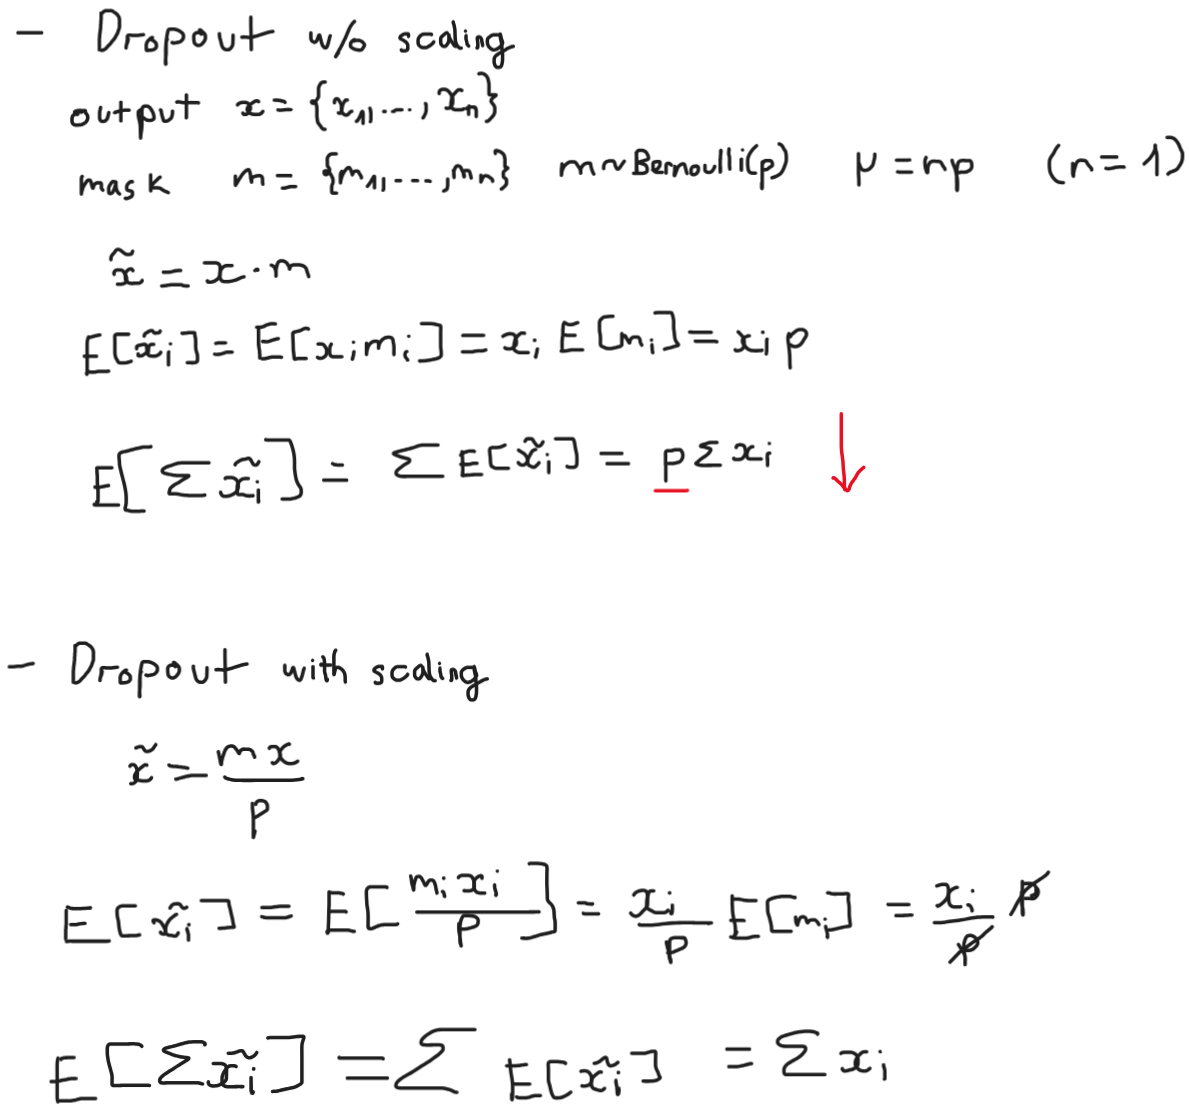

In [59]:
# Implement
class Layer_Dropout:
    def __init__(self, dropout_rate):
        self.rate = 1 - dropout_rate
    
    def forward(self, inputs):
        self.inputs = inputs
        self.binary_mask = np.random.binomial(1, self.rate, inputs.shape) / self.rate
        self.output = inputs * self.binary_mask

    def backward(self, dvalues):
        self.dinputs = dvalues * self.binary_mask

In [60]:
class Dense:
    def __init__(self, n_inputs, n_neurons, \
                 weight_regularizer_l1=0, weight_regularizer_l2=0, \
                    bias_regularizer_l1=0, bias_regularizer_l2=0):
        
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

        self.weight_regularizer_l1 = weight_regularizer_l1
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l1 = bias_regularizer_l1
        self.bias_regularizer_l2 = bias_regularizer_l2
    
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases

    
    def backward(self, dvalues):
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)

        if self.weight_regularizer_l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] -= 1
            self.dweights += self.weight_regularizer_l1 * dL1
        
        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        
        if self.bias_regularizer_l1 > 0:
            dL1 = np.ones_like(self.biases)
            dL1[self.biases < 0] -= 1
            self.dbiases += self.bias_regularizer_l1 * dL1
        
        if self.bias_regularizer_l2 > 0:
            self.dbiases += 2 * self.bias_regularizer_l2 * self.biases

class Dropout:
    def __init__(self, dropout_rate):
        self.rate = 1 - dropout_rate
    
    def forward(self, inputs):
        self.inputs = inputs
        self.binary_mask = np.random.binomial(1, self.rate, inputs.shape) / self.rate
        self.output = inputs * self.binary_mask

    def backward(self, dvalues):
        self.dinputs = self.binary_mask * dvalues

class ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0

class Softmax:
    def forward(self, inputs):
        self.inputs = inputs
        exp_val = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp_val / np.sum(exp_val, axis=1, keepdims=True) 
    
    def backward(self, dvalues):
        self.dinputs = np.empty_like(dvalues)

        for index, (single_output, single_dvalue) in enumerate(zip(self.output, dvalues)):
            single_output = single_output.reshape(-1, 1)
            jacobian = np.diagflat(single_output) - np.dot(single_output, single_output.T)

            self.dinputs[index] = np.dot(jacobian, single_dvalue)

class Loss:
    def calculate(self, y_pred, y_true):
        return np.mean(self.forward(y_pred, y_true))

    def regularization_loss(self, layer):
        reg_loss = 0

        if layer.weight_regularizer_l1 > 0:
            reg_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        if layer.bias_regularizer_l1 > 0:
            reg_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.biases))

        if layer.weight_regularizer_l2 > 0:
            reg_loss += layer.weight_regularizer_l2 * np.sum(layer.weights ** 2)
        if layer.bias_regularizer_l2 > 0:
            reg_loss += layer.bias_regularizer_l2 * np.sum(layer.biases ** 2)
        
        return reg_loss

class CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)

        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred * y_true, axis=1)

        return - np.log(correct_confidences)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])

        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = - y_true / dvalues / samples

class Softmax_CategoricalCrossentropy:
    def __init__(self):
        self.activation = Softmax()
        self.loss = CategoricalCrossentropy()

    def forward(self, inputs, y_true):
        self.activation.forward(inputs)
        self.output = self.activation.output

        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs /= samples

class Adam:
    def __init__(self, learning_rate=0.001, decay=0., eps=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.eps = eps
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.iterations = 0
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate / (1. + self.decay * self.iterations)

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        layer.weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        layer.bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights ** 2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases ** 2

        layer.weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        layer.bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights -= self.current_learning_rate * layer.weight_momentums_corrected / \
                        (np.sqrt(layer.weight_cache_corrected) + self.eps)
        layer.biases -= self.current_learning_rate * layer.bias_momentums_corrected / \
                        (np.sqrt(layer.bias_cache_corrected) + self.eps)

    def post_update_params(self):
        self.iterations += 1

In [61]:
X, y = spiral_data(samples=1000, classes=3)

dense1 = Dense(2, 64, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)
activation1 = ReLU()
dropout1 = Dropout(0.1)
dense2 = Dense(64, 3)
loss_activation = Softmax_CategoricalCrossentropy()

optimizer = Adam(learning_rate=0.05, decay=5e-5)
epochs = 10001

for epoch in range(epochs):
    dense1.forward(X)
    activation1.forward(dense1.output)
    dropout1.forward(activation1.output)
    dense2.forward(dropout1.output)
    
    data_loss = loss_activation.forward(dense2.output, y)
    reg_loss = loss_activation.loss.regularization_loss(dense1) + loss_activation.loss.regularization_loss(dense2)

    loss = data_loss + reg_loss
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions==y)

    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f} (' +
              f'data_loss: {data_loss:.3f}, ' +
              f'reg_loss: {reg_loss:.3f}), ' +
              f'lr: {optimizer.current_learning_rate}')

    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    dropout1.backward(dense2.dinputs)
    activation1.backward(dropout1.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.320, loss: 1.099 (data_loss: 1.099, reg_loss: 0.000), lr: 0.05
epoch: 100, acc: 0.558, loss: 0.916 (data_loss: 0.889, reg_loss: 0.027), lr: 0.04975371909050202
epoch: 200, acc: 0.637, loss: 0.860 (data_loss: 0.826, reg_loss: 0.034), lr: 0.049507401356502806
epoch: 300, acc: 0.639, loss: 0.818 (data_loss: 0.783, reg_loss: 0.035), lr: 0.0492635105177595
epoch: 400, acc: 0.629, loss: 0.807 (data_loss: 0.773, reg_loss: 0.034), lr: 0.04902201088288642
epoch: 500, acc: 0.646, loss: 0.799 (data_loss: 0.767, reg_loss: 0.033), lr: 0.04878286745694912
epoch: 600, acc: 0.648, loss: 0.796 (data_loss: 0.765, reg_loss: 0.032), lr: 0.04854604592455945
epoch: 700, acc: 0.643, loss: 0.799 (data_loss: 0.769, reg_loss: 0.030), lr: 0.048311512633460556
epoch: 800, acc: 0.650, loss: 0.791 (data_loss: 0.762, reg_loss: 0.028), lr: 0.04807923457858552
epoch: 900, acc: 0.639, loss: 0.810 (data_loss: 0.783, reg_loss: 0.027), lr: 0.04784917938657352
epoch: 1000, acc: 0.658, loss: 0.788 (data_los

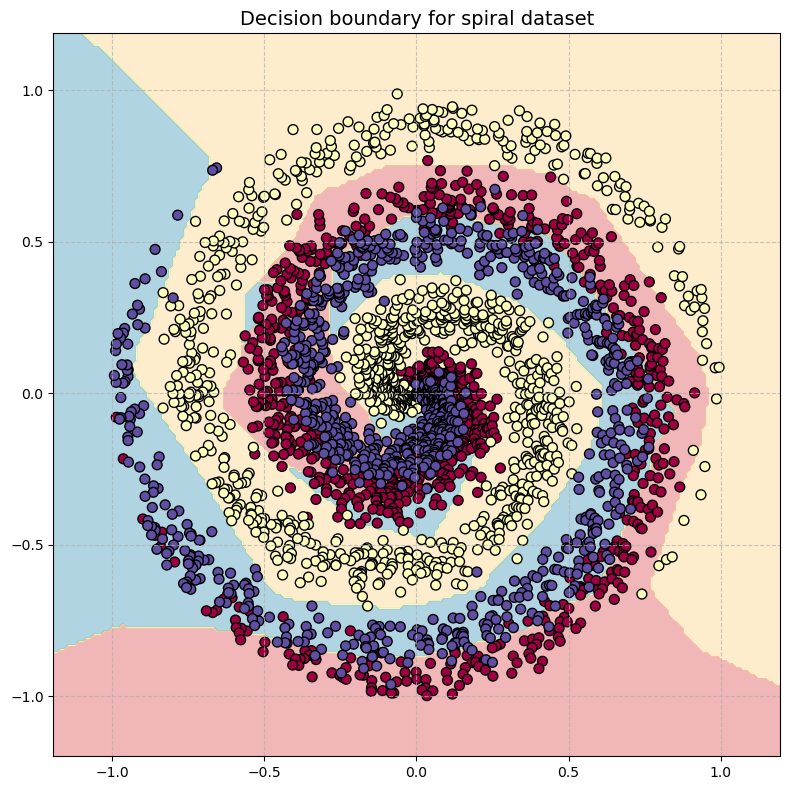

In [62]:
import numpy as np
import matplotlib.pyplot as plt

def spiral_data(samples, classes):
    X = np.zeros((samples * classes, 2))
    y = np.zeros(samples * classes, dtype='uint8')
    for class_number in range(classes):
        ix = range(samples * class_number, samples * (class_number + 1))
        r = np.linspace(0.0, 1, samples)
        t = np.linspace(class_number * 4, (class_number + 1) * 4, samples) + np.random.randn(samples) * 0.2
        X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
        y[ix] = class_number
    return X, y

try:
    X, y = X, y 
except NameError:
    X, y = spiral_data(samples=100, classes=3)

if len(y.shape) == 2:
    y = np.argmax(y, axis=1)

x_min, x_max = X[:, 0].min() - 0.2, X[:, 0].max() + 0.2
y_min, y_max = X[:, 1].min() - 0.2, X[:, 1].max() + 0.2
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

dense1.forward(grid)
activation1.forward(dense1.output)
dense2.forward(activation1.output)
loss_activation.activation.forward(dense2.output)  
grid_predictions = np.argmax(loss_activation.activation.output, axis=1)

grid_predictions = grid_predictions.reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Spectral, alpha=0.4, levels=3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, edgecolors='k', s=50)
plt.title('Decision boundary for spiral dataset', fontsize=14)
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()